# Smit-Beljers model for ferromagnetic resonance

In this notebook you can see how to run a FMR calculation with a theoretical Smit-Beljers model. 

Compared to standard CMTJ here we work in Ms of the A/m units instead of T, and also spherical coordinates.
Use `VectorObj` reference to create objects in convenient frame of reference for you.  
[Here's the reference](https://lemurpwned.github.io/cmtj/api/general-reference/#cmtj.utils.general.VectorObj) 

In [ ]:
import numpy as np

from collections import defaultdict
from cmtj.models import LayerSB, VectorObj, Solver
from cmtj.utils import mu0
from tqdm import tqdm

Ms1 = (
    1.0 / mu0
)  # here we pass the saturation magnetisation in A/m, but in the dynamic model we use T!
Ms2 = 1.2 / mu0
layerA = LayerSB(
    _id=0,
    thickness=1e-9,
    Kv=VectorObj(
        np.deg2rad(0.0), np.deg2rad(0), 1e1
    ),  # for the Kv only phi angle counts !
    Ks=3e4,
    Ms=Ms1,
)
layerB = LayerSB(
    _id=1,
    thickness=1.3e-9,
    Kv=VectorObj(np.deg2rad(0.0), np.deg2rad(0), 1e4),
    Ks=1e1,
    Ms=Ms2,
)

# we indicate the "guess" of the initial position
# it's generally good to align it with the field, but it's not necessary
current_position = [np.deg2rad(89), np.deg2rad(0.1), np.deg2rad(180), np.deg2rad(0.1)]
Hspace = np.linspace(-400e3, 400e3, 50)
result_dictionary = defaultdict(list)
# we perform a sweep over the field magnitude
for Hmag in tqdm(Hspace):
    solver = Solver(
        layers=[layerA, layerB],
        J1=[1e-4],
        J2=[0.0],
        H=VectorObj(np.deg2rad(89), np.deg2rad(0.1), Hmag),
    )
    # check for additional parameters in the solver
    # such as gradient convergence tolerance, max iterations, etc.
    # also in the solver there are root finding parameters
    (t1, p1, t2, p2), frequencies = solver.solve(
        init_position=current_position,
        perturbation=0,
    )
    # frequencies are already in GHz
    for frequency in frequencies:
        result_dictionary["frequency"].append(frequency)
        result_dictionary["Hmag"].append(Hmag)

    # we note the final position of the magnetisation in spherical coordinates
    result_dictionary["theta_1"].append(t1)
    result_dictionary["phi_1"].append(p1)
    result_dictionary["theta_2"].append(t2)
    result_dictionary["phi_2"].append(p2)
    # we reuse the previous solution as the initial guess for the next iteration
    current_position = [t1, p1, t2, p2]

100%|██████████| 8/8 [00:05<00:00,  1.54it/s]


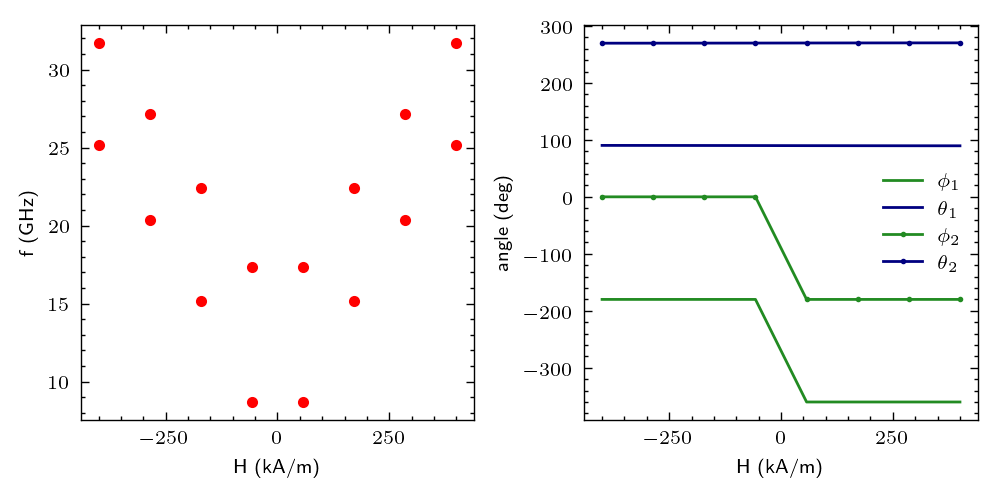

In [8]:
import matplotlib.pyplot as plt

with plt.style.context(["science", "nature"]):
    w, h = plt.figaspect(0.5)
    fig, (ax1, ax2) = plt.subplots(1, 2, dpi=200, figsize=(w, h))
    Hvals = np.asarray(result_dictionary["Hmag"]) / 1e3
    ax1.plot(
        Hvals,
        result_dictionary["frequency"],
        "ro",
        label="frequency",
    )
    ax1.set_xlabel("H (kA/m)")
    ax1.set_ylabel("f (GHz)")

    ax2.plot(
        Hspace / 1e3,
        np.rad2deg(result_dictionary["phi_1"]),
        color="forestgreen",
        label=r"$\phi_1$",
    )
    ax2.plot(
        Hspace / 1e3,
        np.rad2deg(result_dictionary["theta_1"]),
        color="navy",
        label=r"$\theta_1$",
    )

    ax2.plot(
        Hspace / 1e3,
        np.rad2deg(result_dictionary["phi_2"]),
        color="forestgreen",
        label=r"$\phi_2$",
        marker="o",
        markersize=1,
    )
    ax2.plot(
        Hspace / 1e3,
        np.rad2deg(result_dictionary["theta_2"]),
        color="navy",
        label=r"$\theta_2$",
        marker="o",
        markersize=1,
    )
    ax2.legend()
    ax2.set_xlabel("H (kA/m)")
    ax2.set_ylabel("angle (deg)")
    fig.tight_layout()
fig

# Dynamic LLG from Smit-Beljers model, spherical model 

Here, we can also return eigenvectors in addition to eigenvalues (frequencies). Under the hood the solver is a bit different, 
hence we use a slightly different input object.

In [3]:
import numpy as np

from collections import defaultdict
from cmtj.models import LayerDynamic, VectorObj, Solver
from cmtj.utils import mu0
from tqdm import tqdm

Ms1 = (
    1.0 / mu0
)  # here we pass the saturation magnetisation in A/m, but in the dynamic model we use T!
Ms2 = 1.2 / mu0
alpha = 1e-3
layerA = LayerDynamic(
    _id=0,
    thickness=1e-9,
    Kv=VectorObj(
        np.deg2rad(0.0), np.deg2rad(0), 1e1
    ),  # for the Kv only phi angle counts !
    Ks=3e4,
    Ms=Ms1,
    alpha=alpha,
)
layerB = LayerDynamic(
    _id=1,
    thickness=1.3e-9,
    Kv=VectorObj(np.deg2rad(0.0), np.deg2rad(0), 1e4),
    Ks=1e1,
    Ms=Ms2,
    alpha=alpha,
)

# we indicate the "guess" of the initial position
# it's generally good to align it with the field, but it's not necessary
current_position = [np.deg2rad(89), np.deg2rad(0.1), np.deg2rad(180), np.deg2rad(0.1)]
Hspace = np.linspace(-400e3, 400e3, 50)
result_dictionary_dynamic = defaultdict(list)
# we perform a sweep over the field magnitude
for Hmag in tqdm(Hspace):
    solver = Solver(
        layers=[layerA, layerB],
        J1=[1e-4],
        J2=[0.0],
        H=VectorObj(np.deg2rad(89), np.deg2rad(0.1), Hmag),
    )
    # check for additional parameters in the solver
    # such as gradient convergence tolerance, max iterations, etc.
    # also in the solver there are root finding parameters
    # the last param here is an eigenvector
    (t1, p1, t2, p2), frequencies, _ = solver.solve(init_position=current_position)
    # frequencies are already in GHz
    for frequency in frequencies:
        result_dictionary_dynamic["frequency"].append(frequency)
        result_dictionary_dynamic["Hmag"].append(Hmag)

    # we note the final position of the magnetisation in spherical coordinates
    result_dictionary_dynamic["theta_1"].append(t1)
    result_dictionary_dynamic["phi_1"].append(p1)
    result_dictionary_dynamic["theta_2"].append(t2)
    result_dictionary_dynamic["phi_2"].append(p2)
    # we reuse the previous solution as the initial guess for the next iteration
    current_position = [t1, p1, t2, p2]

100%|██████████| 50/50 [00:16<00:00,  2.97it/s]


You see that we get the same result in the end -- even though the dynamic method seems to be a bit faster! There can be still some differences in the results due to the differences in the solver, let us know if and when that happens!

In [4]:
import matplotlib.pyplot as plt

with plt.style.context(["science", "nature"]):
    w, h = plt.figaspect(0.5)
    fig, (ax1, ax2) = plt.subplots(1, 2, dpi=200, figsize=(w, h))
    Hvals = np.asarray(result_dictionary_dynamic["Hmag"]) / 1e3
    ax1.plot(
        Hvals,
        result_dictionary_dynamic["frequency"],
        "bo",
        label="dynamic",
    )
    ax1.plot(
        Hvals,
        result_dictionary["frequency"],
        "ro",
        markersize=0.9,
        label="classical",
    )
    ax1.set_xlabel("H (kA/m)")
    ax1.set_ylabel("f (GHz)")

    ax2.plot(
        Hspace / 1e3,
        np.rad2deg(result_dictionary_dynamic["phi_1"]),
        color="forestgreen",
        label=r"$\phi_1$",
    )
    ax2.plot(
        Hspace / 1e3,
        np.rad2deg(result_dictionary_dynamic["theta_1"]),
        color="navy",
        label=r"$\theta_1$",
    )

    ax2.plot(
        Hspace / 1e3,
        np.rad2deg(result_dictionary_dynamic["phi_2"]),
        color="forestgreen",
        label=r"$\phi_2$",
        marker="o",
        markersize=1,
    )
    ax2.plot(
        Hspace / 1e3,
        np.rad2deg(result_dictionary_dynamic["theta_2"]),
        color="navy",
        label=r"$\theta_2$",
        marker="o",
        markersize=1,
    )
    ax1.legend()
    ax2.legend()
    ax2.set_xlabel("H (kA/m)")
    ax2.set_ylabel("angle (deg)")
    fig.tight_layout()

ValueError: x and y must have same first dimension, but have shapes (100,) and (16,)

# Adding dipole interaction

You can also add dipole interaction to the model. This is done by setting the `Ndipole` parameter to a list of dipole tensors which are 3x3 matrices each. Each dipole tensor should describe the interaction between the corresponding layer and the next one. This is WIP feature and any feedback is appreciated.

In [ ]:
import numpy as np

from collections import defaultdict
from cmtj.models import VectorObj, Solver
from cmtj.utils import mu0
from tqdm import tqdm


def compose_dipole_tensor(V, pos, other):
    r = np.asarray(pos) - np.asarray(other)  # vector from other to pos
    dr = np.linalg.norm(r)  # euclidean distance
    norm = V / (4 * np.pi * dr**5)  # normalization factor
    return [
        norm
        * VectorObj.from_cartesian(
            3 * r[0] ** 2 - dr**2, 3 * r[0] * r[1], 3 * r[0] * r[2]
        ),
        norm
        * VectorObj.from_cartesian(
            3 * r[0] * r[1], 3 * r[1] ** 2 - dr**2, 3 * r[1] * r[2]
        ),
        norm
        * VectorObj.from_cartesian(
            3 * r[0] * r[2], 3 * r[1] * r[2], 3 * r[2] ** 2 - dr**2
        ),
    ]


Ms1 = (
    1.0 / mu0
)  # here we pass the saturation magnetisation in A/m, but in the dynamic model we use T!
Ms2 = 1.2 / mu0
alpha = 1e-3
layerA = LayerSB(
    _id=0,
    thickness=1e-9,
    Kv=VectorObj(
        np.deg2rad(0.0), np.deg2rad(0), 1e1
    ),  # for the Kv only phi angle counts !
    Ks=3e4,
    Ms=Ms1,
)
layerB = LayerSB(
    _id=1,
    thickness=1.3e-9,
    Kv=VectorObj(np.deg2rad(0.0), np.deg2rad(0), 1e4),
    Ks=1e1,
    Ms=Ms2,
)

# we indicate the "guess" of the initial position
# it's generally good to align it with the field, but it's not necessary
current_position = [np.deg2rad(89), np.deg2rad(0.1), np.deg2rad(180), np.deg2rad(0.1)]
Hspace = np.linspace(-400e3, 400e3, 30)
result_dict_dipole = defaultdict(list)
# we perform a sweep over the field magnitude
r = 300e-9
surf = r**2 * np.pi

dipoleA = compose_dipole_tensor(surf * 1e-9, [0, 0, 0], [100e-9, 0, 0])
for Hmag in tqdm(Hspace):
    solver = Solver(
        layers=[layerA, layerB],
        J1=[1e-4],
        J2=[0.0],
        H=VectorObj(np.deg2rad(89), np.deg2rad(0.1), Hmag),
        Ndipole=[dipoleA],
    )
    # check for additional parameters in the solver
    # such as gradient convergence tolerance, max iterations, etc.
    # also in the solver there are root finding parameters
    # the last param here is an eigenvector
    (t1, p1, t2, p2), frequencies = solver.solve(init_position=current_position)
    # frequencies are already in GHz
    for frequency in frequencies:
        result_dict_dipole["frequency"].append(frequency)
        result_dict_dipole["Hmag"].append(Hmag)

    # we note the final position of the magnetisation in spherical coordinates
    result_dict_dipole["theta_1"].append(t1)
    result_dict_dipole["phi_1"].append(p1)
    result_dict_dipole["theta_2"].append(t2)
    result_dict_dipole["phi_2"].append(p2)
    # we reuse the previous solution as the initial guess for the next iteration
    current_position = [t1, p1, t2, p2]

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:22<00:00,  1.35it/s]


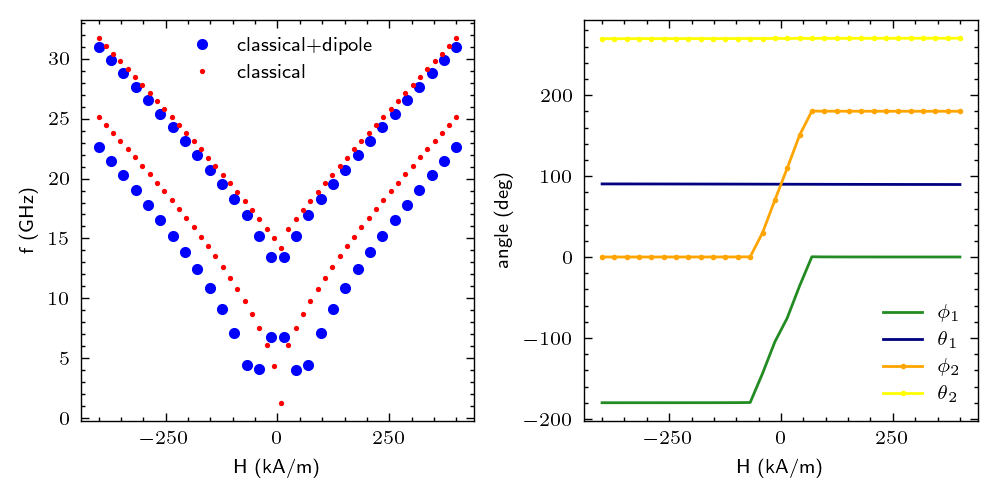

In [ ]:
import matplotlib.pyplot as plt

with plt.style.context(["science", "nature"]):
    w, h = plt.figaspect(0.5)
    fig, (ax1, ax2) = plt.subplots(1, 2, dpi=200, figsize=(w, h))
    ax1.plot(
        np.asarray(result_dict_dipole["Hmag"]) / 1e3,
        result_dict_dipole["frequency"],
        "bo",
        label="classical+dipole",
    )
    ax1.plot(
        np.asarray(result_dictionary["Hmag"]) / 1e3,
        result_dictionary["frequency"],
        "ro",
        markersize=0.9,
        label="classical",
    )
    ax1.set_xlabel("H (kA/m)")
    ax1.set_ylabel("f (GHz)")

    ax2.plot(
        Hspace / 1e3,
        np.rad2deg(result_dict_dipole["phi_1"]),
        color="forestgreen",
        label=r"$\phi_1$",
    )
    ax2.plot(
        Hspace / 1e3,
        np.rad2deg(result_dict_dipole["theta_1"]),
        color="navy",
        label=r"$\theta_1$",
    )

    ax2.plot(
        Hspace / 1e3,
        np.rad2deg(result_dict_dipole["phi_2"]),
        color="orange",
        label=r"$\phi_2$",
        marker="o",
        markersize=1,
    )
    ax2.plot(
        Hspace / 1e3,
        np.rad2deg(result_dict_dipole["theta_2"]),
        color="yellow",
        label=r"$\theta_2$",
        marker="o",
        markersize=1,
    )
    ax1.legend()
    ax2.legend()
    ax2.set_xlabel("H (kA/m)")
    ax2.set_ylabel("angle (deg)")
    fig.tight_layout()

# Voltage FMR 

The dynamic model can be used to compute the voltage FMR. This is done by computing the linearised resistance of the system and then using the voltage drop across the system to compute the frequency shift.

We need both the stationary and linearised angles to compute the linearised resistance, so we find the energy minimum first, and then compute the linearisation using standard Jacobian method. 

We will also use parallelisation to speed up the computation which normally can be pretty slow.

In [ ]:
import numpy as np
from collections import defaultdict
from cmtj.utils.parallel import parallel_vsd_sb_model
from cmtj.models import LayerDynamic, VectorObj, Solver
from cmtj.utils import mu0, FieldScan


def process_frequency(args):
    # this is a fixed function, so we can use it in parallel
    f, Hvecs, layerA, layerB, J1, J2, _ = args
    data = defaultdict(list)
    current_position = [
        np.deg2rad(90),
        np.deg2rad(0.1),
        np.deg2rad(90),
        np.deg2rad(0.1),
    ]
    for H in Hvecs:
        solver = Solver(
            layers=[layerA, layerB],
            J1=J1,
            J2=J2,
            H=VectorObj.from_cartesian(*H),
        )
        current_position = solver.adam_gradient_descent(
            init_position=current_position, max_steps=1e6
        )
        res = solver.linearised_N_spin_diode(
            H=H,
            frequency=f * 1e9,
            Vdc_ex_variable=LayerDynamic.get_Vp_symbol(),
            Vdc_ex_value=1e6,
            zero_pos=current_position,
            phase_shift=0,
            cache_var="H",
        )
        data["lineshape"].append(res)
        data["pos"].append(current_position)
    return data


Ms1 = 1.0 / mu0
Ms2 = 1.2 / mu0
alpha = 1e-3
tpar = 0.2
tperp = -0.2
layerA = LayerDynamic(
    _id=0,
    thickness=1e-9,
    Kv=VectorObj(np.deg2rad(0.0), np.deg2rad(0), 1e1),
    Ks=3e4,
    Ms=Ms1,
    alpha=alpha,
    torque_par=tpar,
    torque_perp=tperp,
)
layerB = LayerDynamic(
    _id=1,
    thickness=1.3e-9,
    Kv=VectorObj(np.deg2rad(0.0), np.deg2rad(0), 1e4),
    Ks=1e1,
    Ms=Ms2,
    alpha=alpha,
    torque_par=-tpar,
    torque_perp=-tperp,
)
hmin = 200e3
N = 70
Hscan, Hvecs = FieldScan.amplitude_scan(
    start=-hmin, stop=hmin, steps=N, theta=89, phi=0.1, back=False
)
fmax = 18
fspace = np.arange(0, fmax, 1)
spin_diode_data = parallel_vsd_sb_model(
    process_frequency,
    frequencies=fspace,
    layers=[layerA, layerB],
    Hvecs=Hvecs,
    J1=[1e-4],
    J2=[0.0],
    n_cores=4,
)

100%|██████████| 18/18 [08:02<00:00, 26.78s/it]


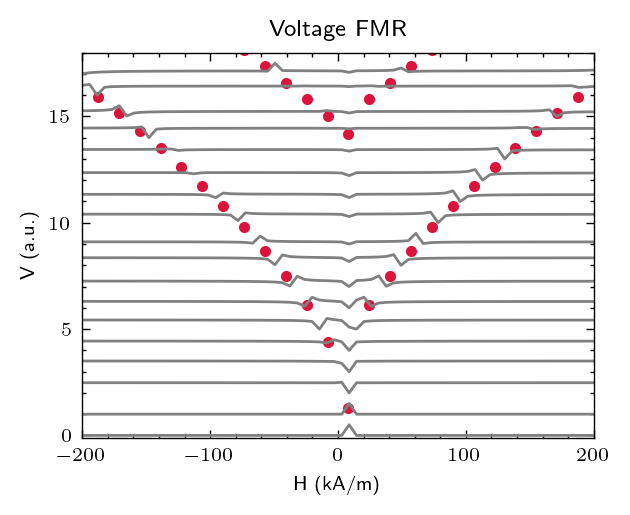

In [ ]:
import matplotlib.pyplot as plt
from cmtj.utils.resistance import Rxx_parallel_bilayer_expr

GMR = 0.1
SMR = 0.01
AMR = 0.1
Vdc = 1
Rlin_func, R_func = Rxx_parallel_bilayer_expr()
with plt.style.context(["science", "nature"]):
    fig, ax = plt.subplots(dpi=200)
    for findx, fdata in enumerate(spin_diode_data):
        V = []
        for linearised, stationary in zip(fdata["lineshape"], fdata["pos"]):
            Rparallel = R_func(GMR, AMR, SMR, AMR, SMR, stationary)
            dRparallel = Rlin_func(GMR, AMR, SMR, AMR, SMR, stationary, linearised)
            Vline = (Vdc / Rparallel) * dRparallel
            V.append(Vline)
        V = np.asarray(V)
        V = (V - V.min()) / (V.max() - V.min()) / 2
        ax.plot(Hscan / 1e3, V + findx, color="gray")
    ax.scatter(
        Hvals,
        result_dictionary["frequency"],
        color="crimson",
        label=r"f",
    )
    ax.set_xlabel("H (kA/m)")
    ax.set_ylabel("V (a.u.)")
    ax.set_title("Voltage FMR")
    ax.set_xlim(-hmin / 1e3, hmin / 1e3)
    ax.set_ylim(-0.1, fmax)

# Extra optimizations

Sometimes computing the roots analytically is not necessarily slower -- as in the example below.
To enable semi-analytical solve we need to pass `prefer_numerical_roots=False`.

Best is to check from example to example if this gives us any speedup. 

```python
solver = Solver(
    layers=[layerA, layerB],
    J1=[1e-4],
    J2=[0.0],
    H=VectorObj(np.deg2rad(89), np.deg2rad(0.1), Hmag),
    prefer_numerical_roots=False,
)
```


In [1]:
import numpy as np

from collections import defaultdict
from cmtj.models import LayerSB, VectorObj, Solver
from cmtj.utils import mu0
from tqdm import tqdm

Ms1 = (
    1.0 / mu0
)  # here we pass the saturation magnetisation in A/m, but in the dynamic model we use T!
Ms2 = 1.2 / mu0
layerA = LayerSB(
    _id=0,
    thickness=1e-9,
    Kv=VectorObj(
        np.deg2rad(0.0), np.deg2rad(0), 1e1
    ),  # for the Kv only phi angle counts !
    Ks=3e4,
    Ms=Ms1,
)
layerB = LayerSB(
    _id=1,
    thickness=1.3e-9,
    Kv=VectorObj(np.deg2rad(0.0), np.deg2rad(0), 1e4),
    Ks=1e1,
    Ms=Ms2,
)

# we indicate the "guess" of the initial position
# it's generally good to align it with the field, but it's not necessary
current_position = [np.deg2rad(89), np.deg2rad(0.1), np.deg2rad(180), np.deg2rad(0.1)]
Hspace = np.linspace(-400e3, 400e3, 50)
result_dictionary = defaultdict(list)
# we perform a sweep over the field magnitude
for Hmag in tqdm(Hspace):
    solver = Solver(
        layers=[layerA, layerB],
        J1=[1e-4],
        J2=[0.0],
        H=VectorObj(np.deg2rad(89), np.deg2rad(0.1), Hmag),
        prefer_numerical_roots=False,
    )
    # check for additional parameters in the solver
    # such as gradient convergence tolerance, max iterations, etc.
    # also in the solver there are root finding parameters
    (t1, p1, t2, p2), frequencies = solver.solve(init_position=current_position)
    # frequencies are already in GHz
    for frequency in frequencies:
        result_dictionary["frequency"].append(frequency)
        result_dictionary["Hmag"].append(Hmag)

    # we note the final position of the magnetisation in spherical coordinates
    result_dictionary["theta_1"].append(t1)
    result_dictionary["phi_1"].append(p1)
    result_dictionary["theta_2"].append(t2)
    result_dictionary["phi_2"].append(p2)
    # we reuse the previous solution as the initial guess for the next iteration
    current_position = [t1, p1, t2, p2]

  0%|          | 0/50 [00:00<?, ?it/s]/Users/jm/repos/cmtj/cmtj/models/general_sb.py:484: UserWarning: LU sometimes causes slow numerical convergence for analytical solve. Setting use_LU_decomposition to False.
  warnings.warn(
  2%|▏         | 1/50 [00:00<00:47,  1.04it/s]/Users/jm/repos/cmtj/cmtj/models/general_sb.py:484: UserWarning: LU sometimes causes slow numerical convergence for analytical solve. Setting use_LU_decomposition to False.
  warnings.warn(
100%|██████████| 50/50 [00:16<00:00,  3.11it/s]


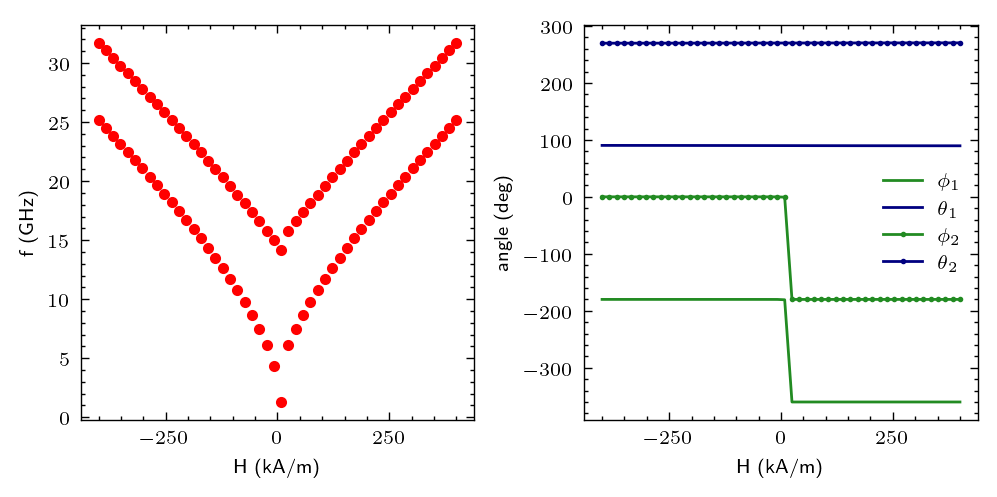

In [2]:
import matplotlib.pyplot as plt

with plt.style.context(["science", "nature"]):
    w, h = plt.figaspect(0.5)
    fig, (ax1, ax2) = plt.subplots(1, 2, dpi=200, figsize=(w, h))
    Hvals = np.asarray(result_dictionary["Hmag"]) / 1e3
    ax1.plot(
        Hvals,
        result_dictionary["frequency"],
        "ro",
        label="frequency",
    )
    ax1.set_xlabel("H (kA/m)")
    ax1.set_ylabel("f (GHz)")

    ax2.plot(
        Hspace / 1e3,
        np.rad2deg(result_dictionary["phi_1"]),
        color="forestgreen",
        label=r"$\phi_1$",
    )
    ax2.plot(
        Hspace / 1e3,
        np.rad2deg(result_dictionary["theta_1"]),
        color="navy",
        label=r"$\theta_1$",
    )

    ax2.plot(
        Hspace / 1e3,
        np.rad2deg(result_dictionary["phi_2"]),
        color="forestgreen",
        label=r"$\phi_2$",
        marker="o",
        markersize=1,
    )
    ax2.plot(
        Hspace / 1e3,
        np.rad2deg(result_dictionary["theta_2"]),
        color="navy",
        label=r"$\theta_2$",
        marker="o",
        markersize=1,
    )
    ax2.legend()
    ax2.set_xlabel("H (kA/m)")
    ax2.set_ylabel("angle (deg)")
    fig.tight_layout()